In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.models import resnet18
from tqdm.autonotebook import tqdm
from copy import deepcopy

## Setup DataLoader and Models 

An important detail is that although we are using the Validation set for `CIFAR10`, we **shuffle** and drop the last batch. This is to ensure that 1) the batches of each epoch are mixed, and 2) each iteration has the same batch size.

In [2]:
transforms = Compose([ToTensor(), 
                      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset = CIFAR10(root='./', train=False, download=True, transform=transforms)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)

Files already downloaded and verified


In [3]:
model1 = resnet18(pretrained=True).cuda()
model1.eval()
model2 = deepcopy(model1)
model2.eval()
print('Dummy models created')

Dummy models created


## Compute CKA 

In [4]:
from cka import CKACalculator

### Basic Usage 

Initializing the `CKACalculator` object will add forward hooks to both `model1` and `model2`. 
The default modules that are hooked are: `Bottleneck`, `BasicBlock`, `Conv2d`, `AdaptiveAvgPool2d`, `MaxPool2d`, and all instances of `BatchNorm`. 
Note that `Bottleneck` and `BasicBlock` are from the `torchvision` implementation, and will not add hooks to any custom implementations of `Bottleneck/BasicBlock`.

For ResNet18, a total of 50 hooks are added.

By default, the intermediate features are flattened with `flatten_hook_fn` and 10 epochs are run.

In [5]:
calculator = CKACalculator(model1=model1, model2=model2, dataloader=dataloader)

No hook function provided. Using flatten_hook_fn.
50 Hooks registered. Total hooks: 50
No hook function provided. Using flatten_hook_fn.
50 Hooks registered. Total hooks: 50


Now we can calculate the CKA matrix 

In [6]:
cka_output = calculator.calculate_cka_matrix()
print(f"CKA output size: {cka_output.size()}")

Epoch 0:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/39 [00:00<?, ?it/s]

CKA output size: torch.Size([50, 50])


#### Visualize the output

Note that the returned matrix has its origin at the top left. In most papers, the CKA matrix is visualized with its origin at the bottom left. Thus, we may flip the matrix first before visualization; however, this example chooses not to.

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7, 7)

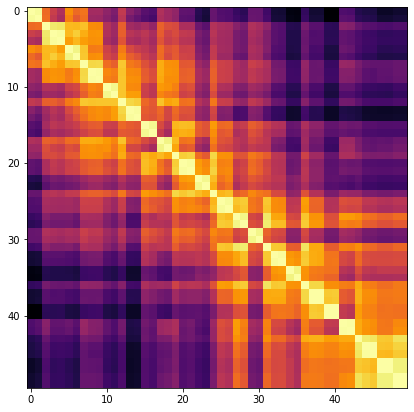

In [8]:
plt.imshow(cka_output.cpu().numpy(), cmap='inferno')

### Advanced Usage 

We can customize other parameters of the `CKACalculator`. 
Most importantly, we can select which modules to hook. 

Before instantiating a new instance of `CKACalculator` on, make sure to first call the `reset` method. 
This clears all hooks registered in the models.

In [9]:
# Reset calculator to clear hooks
calculator.reset()
torch.cuda.empty_cache()

50 handles removed.
50 handles removed.


In [10]:
import torch.nn as nn

Let's consider outputs of `Conv2d` and `BatchNorm2d` only. This will create 40 hooks.

For custom layers, add the custom modules in the same manner as shown below.

In [11]:
layers = (nn.Conv2d, nn.BatchNorm2d)

In [12]:
calculator = CKACalculator(model1=model1, model2=model2, dataloader=dataloader, hook_layer_types=layers)

No hook function provided. Using flatten_hook_fn.
40 Hooks registered. Total hooks: 40
No hook function provided. Using flatten_hook_fn.
40 Hooks registered. Total hooks: 40


In [13]:
cka_output = calculator.calculate_cka_matrix()

Epoch 0:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/39 [00:00<?, ?it/s]

#### Visualize output 

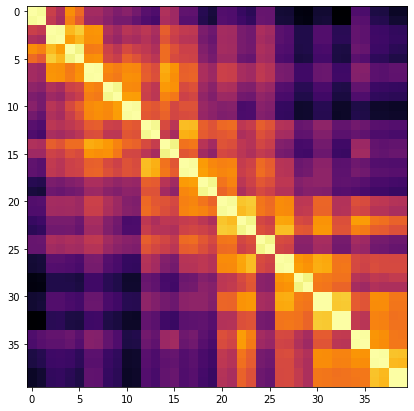

In [14]:
plt.imshow(cka_output.cpu().numpy(), cmap='inferno')